In [1]:
from PIL import Image, ImagePalette, ImageDraw, ImageFont
import numpy as np

# Colors available on lego pick-a-brick as a 1x1 plate
colorNames = {
    "B3D7D1":"Aqua",
    "000000":"Black",
    "E4CD9E":"Brick Yellow",
    "0055BF":"Bright Blue",
    "008F9B":"Bright Bluish Green",
    "4B9F4A":"Bright Green",
    "FE8A18":"Bright Orange",
    "C870A0":"Bright Purple",
    "C91A09":"Bright Red",
    "923978":"Bright Reddish Violet",
    "F2CD37":"Bright Yellow",
    "DFEEA5":"Bright Yellowish Green",
    "FFF03A":"Cool Yellow",
    "078BC9":"Dark Azur",
    "352100":"Dark Brown",
    "184632":"Dark Green",
    "A95500":"Dark Orange",
    "720E0F":"Dark Red",
    "6C6E68":"Dark Stone Grey",
    "0A3463":"Earth Blue",
    "184632":"Earth Green",
    "F8BB3D":"Flame Yellowish Orange",
    "F6D7B3":"Light Nougat",
    "CD6298":"Light Purple",
    "9FC3E9":"Light Royal Blue",
    "36AEBF":"Medium Azure",
    "5A93DB":"Medium Blue",
    "AC78BA":"Medium Lavender",
    "3F3691":"Medium Lilac",
    "AA7D55":"Medium Nougat",
    "A0A5A9":"Medium Stone Grey",
    "9B9A5A":"Olive Green",
    "582A12":"Reddish Brown",
    "A0BCAC":"Sand Green",
    "958A73":"Sand Yellow",
    "FF698F":"Vibrant Coral",
    "FFFFFF":"White",
}

colorValues = {}
for c in colorNames:
  colorValues[colorNames[c]] = c

# TODO: this is gonna take forever
tilePrices = {
  (1,1): 0.05,
  (1,2): 0.07,
  (1,3): 0.07,
  (1,4): 0.10,
  (1,5): 0.22
}

def quantizePalette(im, palette):
    p = Image.new("P", (1,1))
    palette += (768-len(palette))*[0]
    p.putpalette(palette)
    return im.convert("RGB").quantize(palette=p)

def hex_to_rgb(hex):
  rgb = []
  for i in (0, 2, 4):
    decimal = int(hex[i:i+2], 16)
    rgb.append(decimal)
  return rgb

def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

palette = []
for x in colorNames:
  palette += hex_to_rgb(x)

Original Image:


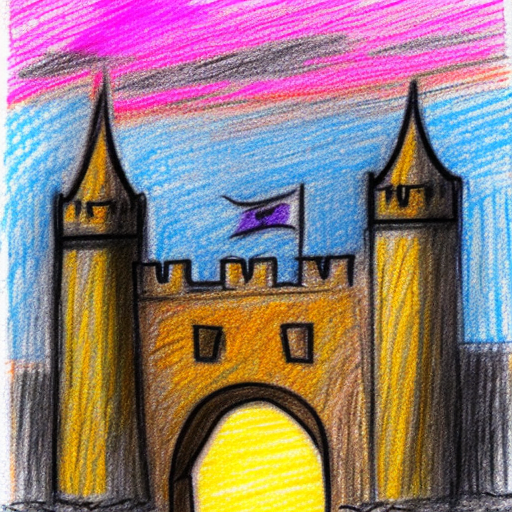

Resized to mosaic resolution:


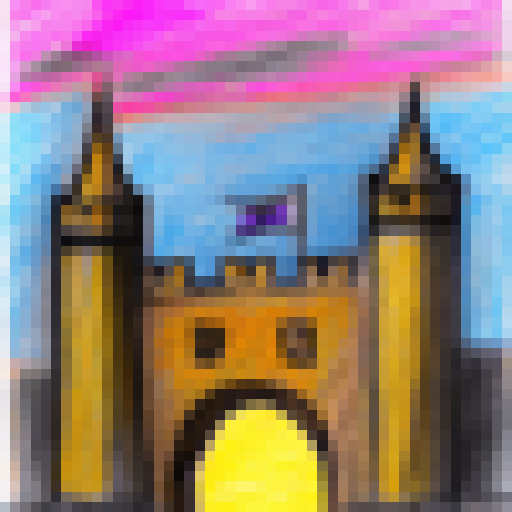

Palettized to lego colors:


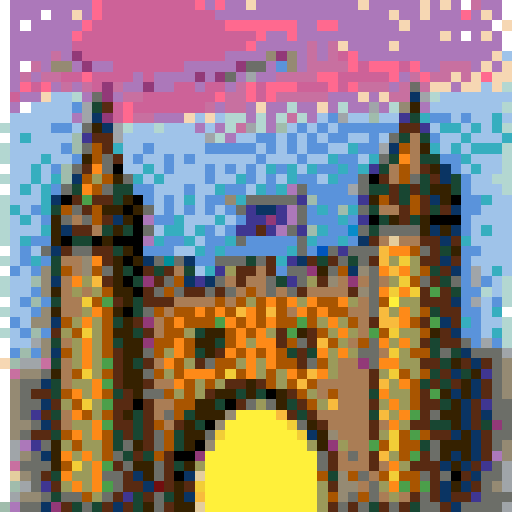

In [2]:
tilesW = 50
tilesH = 50
imagePath = r"./test.png"

previewImageSize = (512,512)
img = Image.open(imagePath)
previewImg = img.resize(previewImageSize, resample=Image.Resampling.NEAREST)
print("Original Image:")
display(previewImg)
img = img.resize((tilesW, tilesH))
previewImg = img.resize(previewImageSize, resample=Image.Resampling.NEAREST)
print("Resized to mosaic resolution:")
display(previewImg)
img = quantizePalette(img, palette)
img = img.convert("RGB")
previewImg = img.resize(previewImageSize, resample=Image.Resampling.NEAREST)
print("Palettized to lego colors:")
display(previewImg) # palettized image

In [3]:
colorCounts = {}
for x in range(tilesW):
    for y in range(tilesH):
        col = img.getpixel((x, y))
        col = rgb_to_hex(col).upper()
        colorName = colorNames[col]
        if colorName not in colorCounts:
          colorCounts[colorName] = 1
        else:
          colorCounts[colorNames[col]] += 1

print(f"{tilesW}x{tilesH} ({tilesW*tilesH}) tiles, ~USD{tilesW*tilesH*tilePrices[(1,1)]}")
print(f"Requires {len(colorCounts)} different colors:")
for c in colorCounts:
  print(f"{c}: {colorCounts[c]}")

50x50 (2500) tiles, ~USD125.0
Requires 34 different colors:
White: 46
Aqua: 45
Light Nougat: 34
Sand Green: 16
Medium Lavender: 236
Light Purple: 132
Light Royal Blue: 242
Medium Azure: 75
Medium Blue: 169
Bright Purple: 55
Sand Yellow: 48
Medium Stone Grey: 28
Brick Yellow: 4
Vibrant Coral: 44
Dark Stone Grey: 177
Reddish Brown: 194
Medium Lilac: 29
Earth Blue: 66
Earth Green: 107
Dark Brown: 107
Bright Reddish Violet: 21
Black: 32
Dark Orange: 145
Medium Nougat: 109
Olive Green: 103
Bright Orange: 80
Bright Yellow: 20
Bright Green: 21
Flame Yellowish Orange: 18
Dark Red: 1
Bright Bluish Green: 1
Cool Yellow: 93
Bright Blue: 1
Dark Azur: 1


In [4]:
# stolen from https://stackoverflow.com/questions/38277859/obtain-location-of-largest-rectangle and slightly modified
from collections import namedtuple

Info = namedtuple('Info', 'start height')

# returns height, width, and position of the top left corner of the largest
#  rectangle with the given value in mat
def max_size(mat, value=0):
    it = iter(mat)
    hist = [int(el==value) for el in next(it, [])]
    max_size_start, start_row = max_rectangle_size(hist), 0
    for i, row in enumerate(it):
        hist = [(1+h) if el == value else 0 for h, el in zip(hist, row)]
        mss = max_rectangle_size(hist)
        if area(mss) > area(max_size_start):
            max_size_start, start_row = mss, i+2-mss[0]
    return max_size_start[:2], (start_row, max_size_start[2])

# returns height, width, and start column of the largest rectangle that
#  fits entirely under the histogram
def max_rectangle_size(histogram):
    stack = []
    top = lambda: stack[-1]
    max_size_start = (0, 0, 0) # height, width, start of the largest rectangle
    pos = 0 # current position in the histogram
    for pos, height in enumerate(histogram):
        start = pos # position where rectangle starts
        while True:
            if not stack or height > top().height:
                stack.append(Info(start, height)) # push
            elif stack and height < top().height:
                max_size_start = max(
                    max_size_start,
                    (top().height, pos - top().start, top().start),
                    key=area)
                start, _ = stack.pop()
                continue
            break # height == top().height goes here

    pos += 1
    for start, height in stack:
        max_size_start = max(max_size_start, (height, pos - start, start),
            key=area)

    return max_size_start

def area(size): return size[0]*size[1]

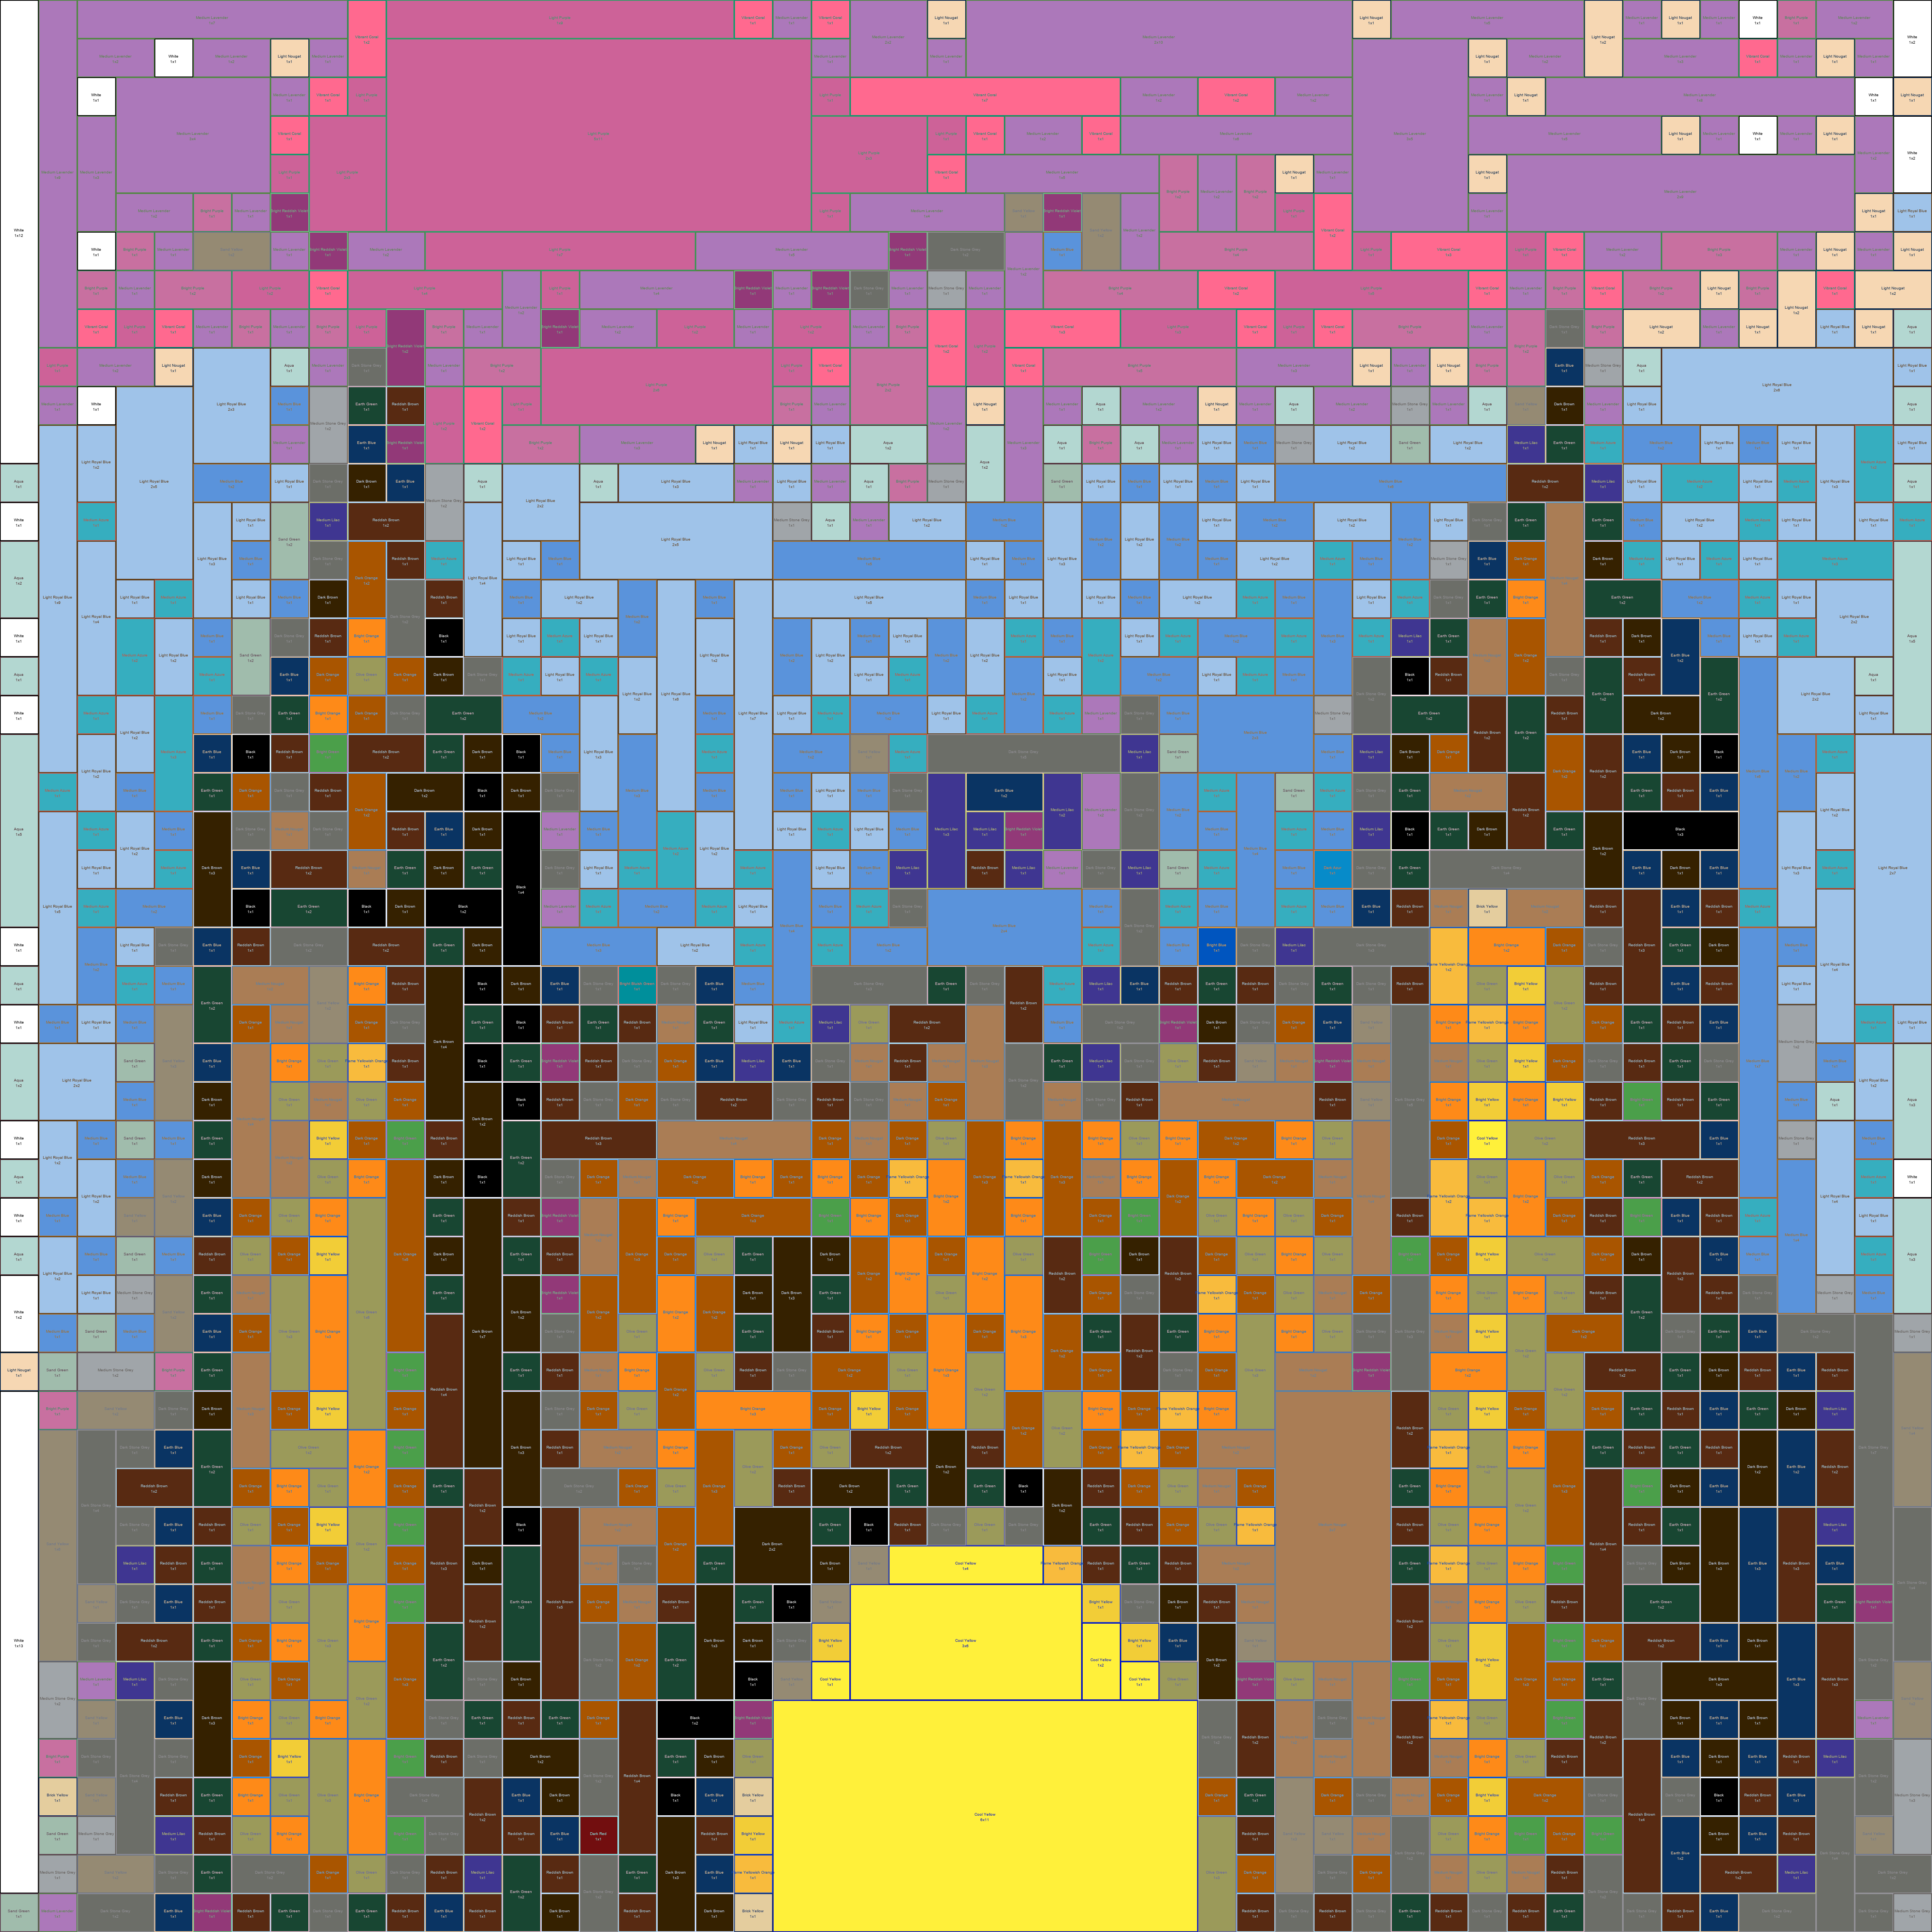

In [5]:
finalPartsList = {}

img_np = np.asarray(img)
tileSize = np.array([tilesW, tilesH])
sizeMultiplier = np.array([100, 100])
displayImgSize = tileSize*sizeMultiplier
img_draw = img.resize(displayImgSize, resample=Image.Resampling.NEAREST)
draw = ImageDraw.Draw(img_draw)
font = ImageFont.truetype("arial.ttf", 10)
lineWidthRadius = 1

for colName in colorCounts:
    finalPartsList[colName] = {}
    colHex = colorValues[colName]
    rgb = np.array(hex_to_rgb(colHex), dtype='uint8')
    drawColor = 255-rgb

    mat = np.all(img_np == rgb, axis=-1).astype('uint8')
    while True:
        rectSize, rectPos = max_size(mat, 1)
        if rectSize[0] == 0:
            break

        rectSize = np.flip(np.array(rectSize))
        rectPos = np.flip(np.array(rectPos))
        rectSize_pixels = rectSize*sizeMultiplier-lineWidthRadius
        rectPos_pixels = rectPos*sizeMultiplier
        rectSize_name = tuple(np.sort(rectSize))

        drawCoords = (tuple(rectPos_pixels) + tuple(rectPos_pixels+rectSize_pixels))
        draw.rectangle(drawCoords, outline=tuple(drawColor), width=lineWidthRadius*2)
        draw.text(tuple(rectPos_pixels+rectSize_pixels/2), f"{colName}\n{rectSize_name[0]}x{rectSize_name[1]}", fill=tuple(drawColor), font=font, anchor="ms", align="center")
        mat[rectPos[1]:rectPos[1]+rectSize[1], rectPos[0]:rectPos[0]+rectSize[0]] = 0

        if rectSize_name not in finalPartsList[colName]:
          finalPartsList[colName][rectSize_name] = 1
        else:
          finalPartsList[colName][rectSize_name] += 1

display(img_draw)

In [6]:
outputStr = "Required Parts List"
for col in finalPartsList:
    outputStr += f"\n{col} plates: "
    for tileSize in finalPartsList[col]:
        outputStr += f"{finalPartsList[col][tileSize]} {tileSize[0]}x{tileSize[1]}, "

print(outputStr)

Required Parts List
White tiles: 1 1x13, 1 1x12, 3 1x2, 15 1x1, 
Aqua tiles: 2 1x5, 2 1x3, 4 1x2, 21 1x1, 
Light Nougat tiles: 4 1x2, 26 1x1, 
Sand Green tiles: 2 1x2, 12 1x1, 
Medium Lavender tiles: 1 2x10, 1 2x9, 1 3x5, 1 3x4, 1 1x9, 1 1x8, 1 1x7, 1 1x6, 4 1x5, 1 2x2, 2 1x4, 5 1x3, 21 1x2, 52 1x1, 
Light Purple tiles: 1 5x11, 1 2x6, 1 1x9, 1 1x7, 2 2x3, 1 1x5, 1 1x4, 1 1x3, 5 1x2, 15 1x1, 
Light Royal Blue tiles: 1 2x7, 1 2x6, 2 2x5, 1 1x9, 1 1x7, 1 2x3, 1 1x6, 2 1x5, 4 2x2, 4 1x4, 6 1x3, 25 1x2, 58 1x1, 
Medium Azure tiles: 2 1x3, 5 1x2, 59 1x1, 
Medium Blue tiles: 1 2x4, 1 1x7, 2 1x6, 1 2x3, 1 1x5, 3 1x4, 3 1x3, 23 1x2, 64 1x1, 
Bright Purple tiles: 1 1x5, 2 1x4, 1 2x2, 2 1x3, 7 1x2, 18 1x1, 
Sand Yellow tiles: 1 1x6, 1 1x4, 2 1x3, 8 1x2, 16 1x1, 
Medium Stone Grey tiles: 1 1x3, 5 1x2, 15 1x1, 
Brick Yellow tiles: 4 1x1, 
Vibrant Coral tiles: 1 1x7, 2 1x3, 6 1x2, 19 1x1, 
Dark Stone Grey tiles: 1 1x7, 2 1x5, 5 1x4, 3 1x3, 24 1x2, 83 1x1, 
Reddish Brown tiles: 1 1x5, 4 1x4, 6 1x3, 3